In [1]:
!pip install nonechucks

  Created wheel for nonechucks: filename=nonechucks-0.4.0-cp36-none-any.whl size=11546 sha256=b5ae24591c480fa481f33cc5b55356cfe0601aee74192b474800c4316d89c1ea
  Stored in directory: /root/.cache/pip/wheels/00/b3/4e/4e30d5f934293de9abab2bfe6a4ce6fe77bf936c625133dd9c
Successfully built nonechucks


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import nonechucks as nc

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import os
os.chdir('/kaggle/input/chinese-zodiac-signs')

In [3]:
# remove corrupted images from the datasets
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

for (dirpath, dirnames, filenames) in os.walk('.'):
    for file in filenames:
        try:
            im = Image.open(dirpath + '/' + file)
            if im.mode != 'RGB': im.convert('RGB').save(dirpath + '/' + file)
        except:
            continue

/opt/conda/lib/python3.6/site-packages/PIL/Image.py:2685: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
# load datasets
data_dir = 'signs'

batch_size = 20

transforms = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transforms)

train_data = nc.SafeDataset(train_data)
valid_data = nc.SafeDataset(valid_data)
test_data = nc.SafeDataset(test_data)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
# check if data loading was succesfull
print('No. training images: ', len(train_data))
print('No. validation images: ', len(valid_data))
print('No. test images: ', len(test_data))

No. training images:  7197
No. validation images:  650
No. test images:  660


In [7]:
# method to reverse normalization of the images
def inv_normalize(img):
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406
    return img

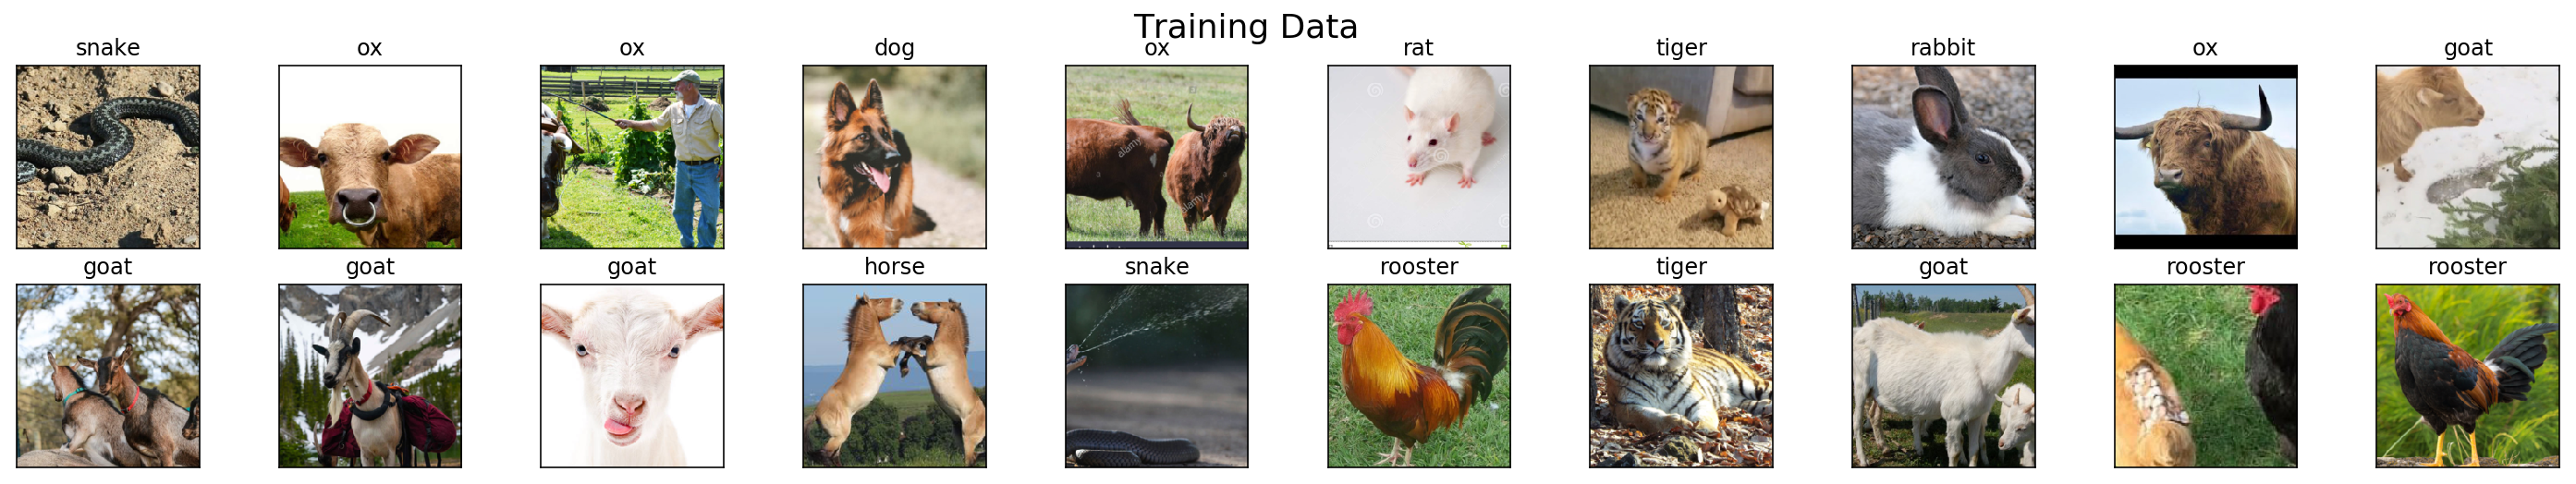

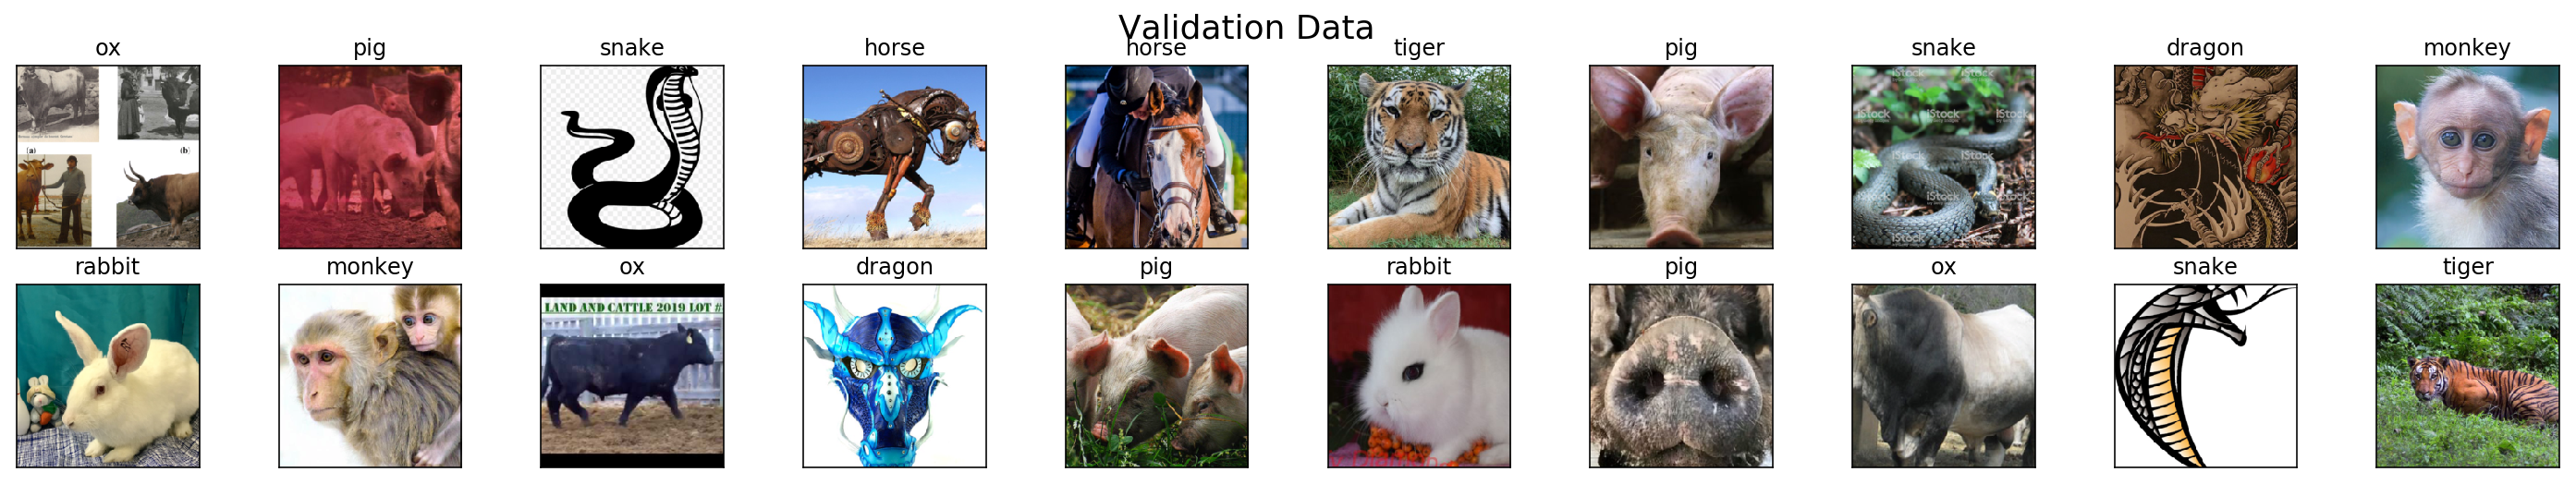

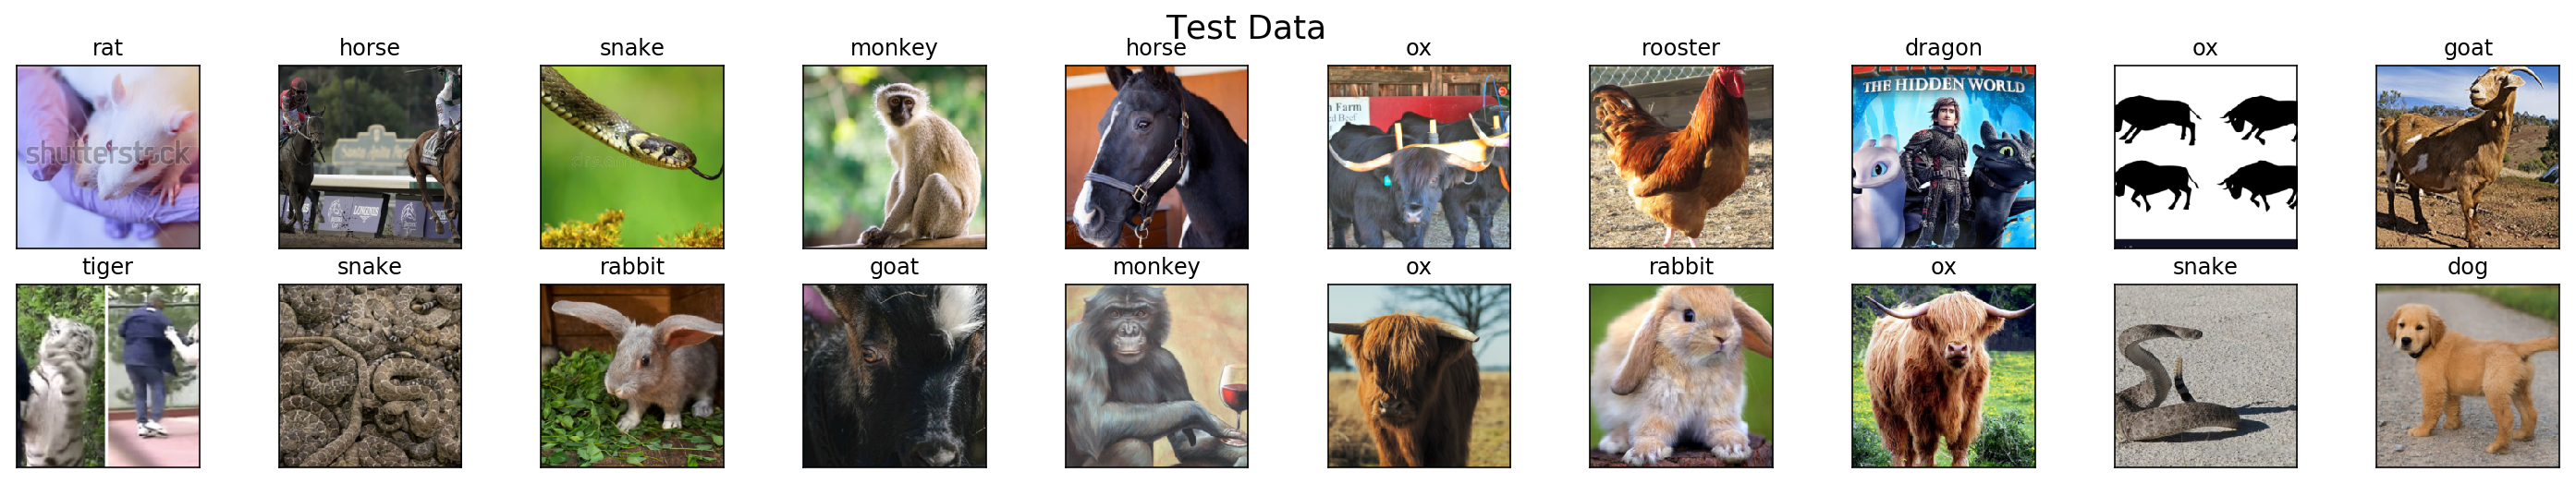

In [8]:
# visualize some training data (images & labels)
dataiter_train = iter(trainloader)
dataiter_valid = iter(validloader)
dataiter_test = iter(testloader)
images_train, labels_train = dataiter_train.next()
images_valid, labels_valid = dataiter_valid.next()
images_test, labels_test = dataiter_test.next()
images_train, images_valid, images_test = images_train.numpy(), images_valid.numpy(), images_test.numpy()

classes = ['dog', 'dragon', 'goat', 'horse', 'monkey', 'ox', 'pig', 'rabbit', 'rat', 'rooster', 'snake', 'tiger']

fig = plt.figure(figsize=(25, 4))
fig.suptitle('Training Data', fontsize=18)
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    img = inv_normalize(images_train[i])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(classes[labels_train[i]])
    
fig = plt.figure(figsize=(25, 4))
fig.suptitle('Validation Data', fontsize=18)
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    img = inv_normalize(images_valid[i]) 
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(classes[labels_valid[i]])
    
fig = plt.figure(figsize=(25, 4))
fig.suptitle('Test Data', fontsize=18)
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    img = inv_normalize(images_test[i])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(classes[labels_test[i]])

In [9]:
# load pretrained model 
model = models.resnext101_32x8d(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:05<00:00, 62.9MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [10]:
# freeze parameters of the pretrained model
for parameter in model.parameters():
    parameter.requires_grad = False

In [11]:
# redefine last fully connected layer
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(512, 12))

In [12]:
# move model to GPU
if train_on_gpu:
    model.cuda()

In [13]:
# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=0.003, momentum=0.9)

In [14]:
# Training the modified fully connected layer
n_epochs = 15

valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    # training
    model.train()
    # iterate over training data
    for data, target in trainloader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
                
    # validation
    model.eval()
    # iterate over validation data
    for data, target in validloader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)

    # monitor training and validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '/kaggle/working/model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.320313 	Validation Loss: 0.283552
Validation loss decreased (inf --> 0.283552).  Saving model ...
Epoch: 2 	Training Loss: 0.473341 	Validation Loss: 0.204500
Validation loss decreased (0.283552 --> 0.204500).  Saving model ...
Epoch: 3 	Training Loss: 0.386350 	Validation Loss: 0.202316
Validation loss decreased (0.204500 --> 0.202316).  Saving model ...
Epoch: 4 	Training Loss: 0.353379 	Validation Loss: 0.190894
Validation loss decreased (0.202316 --> 0.190894).  Saving model ...
Epoch: 5 	Training Loss: 0.322666 	Validation Loss: 0.178898
Validation loss decreased (0.190894 --> 0.178898).  Saving model ...
Epoch: 6 	Training Loss: 0.293400 	Validation Loss: 0.173869
Validation loss decreased (0.178898 --> 0.173869).  Saving model ...
Epoch: 7 	Training Loss: 0.300917 	Validation Loss: 0.189968
Epoch: 8 	Training Loss: 0.279592 	Validation Loss: 0.176064
Epoch: 9 	Training Loss: 0.264224 	Validation Loss: 0.178053
Epoch: 10 	Training Loss: 0.254880 	Valida

KeyboardInterrupt: 

In [15]:
# load best performing model
trained_model = model
trained_model.load_state_dict(torch.load('/kaggle/working/model.pt'), strict=False)
if train_on_gpu:
    trained_model.cuda()
trained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [16]:
# Testing
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
# iterate over test data
for data, target in testloader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    output = trained_model(data)
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(12):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.193863

Test Accuracy of   dog: 96.36% (53/55)
Test Accuracy of dragon: 90.91% (50/55)
Test Accuracy of  goat: 89.09% (49/55)
Test Accuracy of horse: 98.18% (54/55)
Test Accuracy of monkey: 94.55% (52/55)
Test Accuracy of    ox: 94.55% (52/55)
Test Accuracy of   pig: 96.36% (53/55)
Test Accuracy of rabbit: 89.09% (49/55)
Test Accuracy of   rat: 90.91% (50/55)
Test Accuracy of rooster: 94.55% (52/55)
Test Accuracy of snake: 90.91% (50/55)
Test Accuracy of tiger: 94.55% (52/55)

Test Accuracy (Overall): 93.33% (616/660)


In [ ]:
# visualize testing
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = trained_model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

images = images.cpu()
# plot the results
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    img = inv_normalize(images[i]) 
    img = img[:3,:,:]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                 color=("green" if preds[i]==labels[i].item() else "red"))